In [1]:
import pandas as pd
import numpy as np

from glob import glob
import re

from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from scipy.stats import mannwhitneyu as MWU
from math import log

In [7]:
greg = {}

greg['Dre'] = pd.read_csv("./data/genomic_regions/GREAT_dre.bed", sep='\t', header=None)
greg['Dre'].columns = ['chrom','start','end','gene1','score','strand']
greg['Dre']['score'] = greg['Dre']['end'] - greg['Dre']['start']

greg['Bla'] = pd.read_csv("./data/genomic_regions/GREAT_bla.bed", sep='\t', header=None)
greg['Bla'].columns = ['chrom','start','end','gene1','score','strand']
greg['Bla']['score'] = greg['Bla']['end'] - greg['Bla']['start']

greg['Ola'] = pd.read_csv("./data/genomic_regions/GREAT_ola.bed", sep='\t', header=None)
greg['Ola'].columns = ['chrom','start','end','gene1','score','strand']
greg['Ola']['score'] = greg['Ola']['end'] - greg['Ola']['start']

greg['Mmu'] = pd.read_csv("./data/genomic_regions/GREAT_mmu.bed", sep='\t', header=None)
greg['Mmu'].columns = ['chrom','start','end','gene1','score','strand']
greg['Mmu']['score'] = greg['Mmu']['end'] - greg['Mmu']['start']

print( [(k,len(v)) for k,v in greg.items()])

[('Mmu', 18842), ('Bla', 20569), ('Dre', 20053), ('Ola', 15978)]


In [8]:
stages = {}
stages['Bla'] = ['15']
stages['Dre'] = ["8som"]
stages['Ola'] = ["8som"]

In [9]:
genome_size = {'Dre': 1.37e9,
              'Bla' : 0.5e9,
              'Ola' : 0.87e9}
rep_regions = {'Dre' : 716927489,
              'Bla' : 152452412,
               'Ola': 23221380
              }
avail_genome = { k:genome_size[k]-rep_regions[k] for k in ['Dre','Bla','Ola']  }
avail_genome

{'Bla': 347547588.0, 'Dre': 653072511.0, 'Ola': 846778620.0}

In [85]:
# # This is how many reads the bla sample has.
# # It was much easier to hard code this number than to count in this notebook:
Bla_coverage = 9200000*1000/ avail_genome['Bla']
fixcols =[1,10,20,30,40,50,60,70,80,90,100]

In [86]:
greg_ = BT().from_dataframe(greg['Dre']).sort()
pre_cols = ['chrom','start','end','gene','width','strand']
cols = []
    
for thing in glob("./data/atac_peaks/downsampling/zebra_danRer10_8som_*_idr01Peaks.bed.gz"):
    reads = int(re.findall(r"[0-9]+", thing)[2])
    
    cov = reads*1000/avail_genome['Dre']
    cov = round(cov*100 / Bla_coverage,2)
    cov = int(round(cov))
    
    cols.append( cov )
    greg_ = greg_.intersect(b=BT( thing ), nonamecheck=True, c=True)

counts_Dre = greg_.to_dataframe(names=pre_cols+cols)   
counts_Dre = counts_Dre[pre_cols+ sorted(cols)]
counts_Dre.columns = pre_cols + fixcols
dre_melt = pd.melt(counts_Dre[['gene']+fixcols], id_vars='gene')
dre_melt.columns = ['gene','pc','count']

In [88]:
greg_ = BT().from_dataframe(greg['Ola']).sort()
pre_cols = ['chrom','start','end','gene','width','strand']
cols = []
    
for thing in glob("./data/atac_peaks/downsampling/medaka_8som_*_idr01Peaks.bed.gz"):
    reads = int(re.findall(r"[0-9]+", thing)[1])
    
    cov = reads*1000/avail_genome['Ola']
    cov = round(cov*100 / Bla_coverage,2)
    cov = int(round(cov))
    
    cols.append( cov )
    greg_ = greg_.intersect(b=BT( thing ), nonamecheck=True, c=True)

counts_Ola = greg_.to_dataframe(names=pre_cols+cols)   
counts_Ola = counts_Ola[pre_cols+ sorted(cols)]
counts_Ola.columns = pre_cols + fixcols
ola_melt = pd.melt(counts_Ola[['gene']+fixcols], id_vars='gene')
ola_melt.columns = ['gene','pc','count']

In [114]:
org = "bla"
stage='15'

full_peaks = './data/atac_peaks/amphi_15_idrpeaks.bed'
sub_peaks = './data/atac_peaks/downsampling/amphi_15_9200000_idr01Peaks.bed.gz'


greg_ = BT().from_dataframe(greg['Bla']).sort()
cols = ['chrom','start','end','gene','width','strand']

greg_ = greg_.intersect(b=BT( full_peaks ), nonamecheck=True, c=True)
greg_ = greg_.intersect(b=BT( sub_peaks ), nonamecheck=True, c=True)

counts_Bla = greg_.to_dataframe(names=cols + [101,100])

bla_melt = pd.melt(counts_Bla[['gene',101,100]], id_vars='gene')
bla_melt.columns = ['gene','pc','count']

In [115]:
bla_melt['species'] = 'bla'
ola_melt['species'] = 'ola'
dre_melt['species'] = 'dre'

In [116]:
bla_melt.head(2)

,gene,pc,count,species
0,BL09450,101,10,bla
1,BL10006,101,17,bla


In [117]:
ola_melt.head(2)

,gene,pc,count,species
0,ENSORLG00000000003,1,0,ola
1,ENSORLG00000000007,1,0,ola


In [118]:
dre_melt.head(2)

,gene,pc,count,species
0,ENSDARG00000063895,1,0,dre
1,ENSDARG00000063899,1,0,dre


In [119]:
toplot = pd.concat([dre_melt, ola_melt, bla_melt])
toplot.sample(5)

,gene,pc,count,species
212307,ENSDARG00000055899,100,5,dre
54756,ENSDARG00000007175,20,4,dre
1940,ENSDARG00000003169,1,0,dre
175275,ENSORLG00000020625,100,0,ola
105277,ENSDARG00000102047,50,31,dre


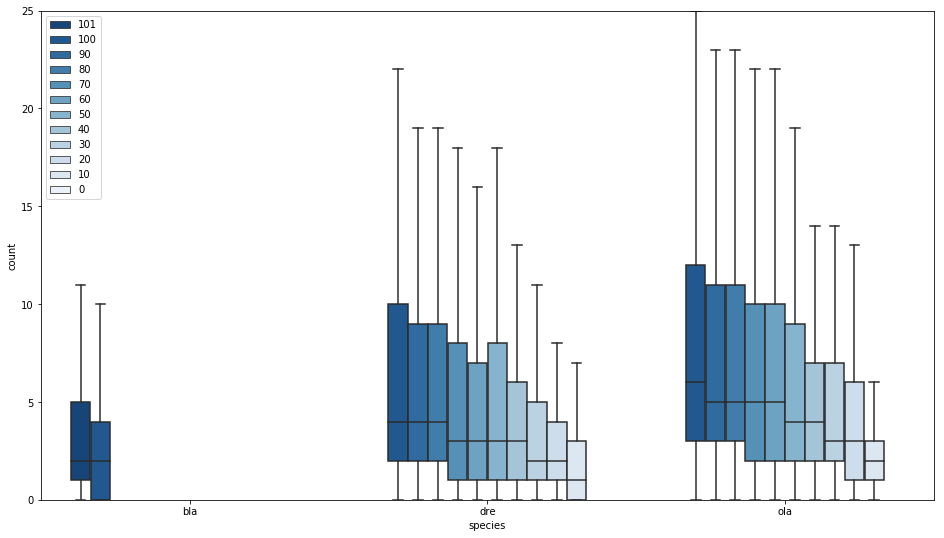

In [121]:
plt.figure(figsize=(16,9))



sns.boxplot(
    data=toplot,
    
    x = 'species',
    order= ['bla','dre','ola'],
    hue='pc',
    hue_order=[101,100,90,80,70,60,50,40,30,20,10,0],
    
    fliersize=0,
    y='count',
    palette='Blues_r'
)

plt.ylim((0,25))
plt.legend(loc='upper left')

In [131]:
lot = []
blavals = toplot.loc[(toplot.species=='bla') & (toplot.pc==101),'count'].values
blavals_sub = toplot.loc[(toplot.species=='bla') & (toplot.pc==100),'count'].values

for gn,g in toplot.groupby(['species','pc']):
    species,pc = gn
    if species=='bla':
        continue
    pv = MWU( g['count'].values , blavals, alternative='greater' ).pvalue
    pv_sub = MWU( g['count'].values , blavals_sub, alternative='greater' ).pvalue
    
    lot.append([ species, pc, pv_sub,pv])
    
    
df = pd.DataFrame(lot)
df.columns = ['species','% of reads','pVal to downsampled Amphi','pVal to full Amphi']
df

,species,% of reads,pVal to downsampled Amphi,pVal to full Amphi
0,dre,1,1.000000e+00,1.000000e+00
1,dre,10,1.000000e+00,1.000000e+00
2,dre,20,5.210865e-20,1.000000e+00
3,dre,30,2.131912e-37,9.985630e-01
4,dre,40,3.859252e-283,1.817653e-94
5,dre,50,0.000000e+00,3.299567e-283
6,dre,60,0.000000e+00,2.732288e-240
7,dre,70,0.000000e+00,3.523587e-268
8,dre,80,0.000000e+00,0.000000e+00
9,dre,90,0.000000e+00,0.000000e+00
